In [3]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

Load Yamnet classes

In [4]:
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

Load predictions and labels

In [5]:
with open('data/yamnet_scores/yamnet_scores_2020.pickle', 'rb') as file:
    pred_scores_20 = pickle.load(file)

with open('data/yamnet_scores/yamnet_scores_2021.pickle', 'rb') as file:
    pred_scores_21 = pickle.load(file)

pred_score_* are dictionaries {filename: (prediction, embedding, spectrogram)}

In [6]:
[el.shape for el in list(pred_scores_20.values())[0]], [el.shape for el in list(pred_scores_21.values())[0]]

([TensorShape([63, 521]), TensorShape([63, 1024]), TensorShape([3072, 64])],
 [TensorShape([60, 521]), TensorShape([60, 1024]), TensorShape([2928, 64])])

prediction are shape (n_frames, n_classes), each element is the "probability" of the occurrence of the corresponding event (to the index)

embeddings are (n_frames, embedding_dim)

Let's check the distribution of the biggest probabilities for each frame

In [7]:
max_prob_series = pd.Series(np.concatenate([np.max(pred.numpy(), axis=1) for pred, _, _ in pred_scores_20.values()]))
max_prob_series.describe()

count    18000.000000
mean         0.494309
std          0.279741
min          0.034836
25%          0.255900
50%          0.433233
75%          0.721430
max          1.000000
dtype: float64

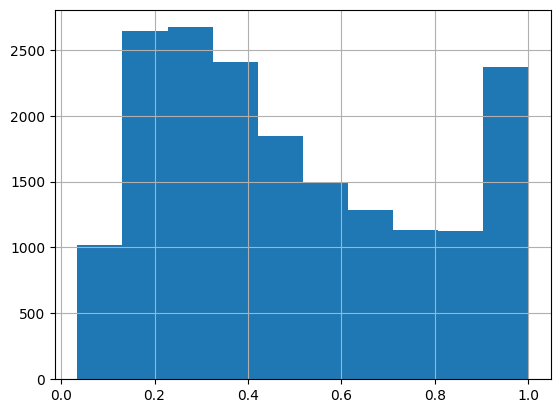

In [8]:
max_prob_series.hist()
plt.show()

Load the labels

In [9]:
df_20 = pd.read_csv('data/yamnet_foreground_labels_20.csv')
df_21 = pd.read_csv('data/yamnet_foreground_labels_21.csv')
df_20.head()

,file,frame_number,label_0,label_1,label_2,predicted_label
0,fu_2jeb5yktarbeiyk.wav,3,Nature/Animals/Bird,None,None,Environmental noise
1,fu_2jeb5yktarbeiyk.wav,4,Nature/Animals/Bird,None,None,Environmental noise
2,fu_2jeb5yktarbeiyk.wav,5,Nature/Animals/Bird,None,None,Environmental noise
3,fu_2jeb5yktarbeiyk.wav,6,Nature/Animals/Bird,None,None,Animal
4,fu_2jeb5yktarbeiyk.wav,7,Nature/Animals/Bird,None,None,Animal


In [10]:
real_classes_20 = np.unique(df_20[[col for col in df_20.columns if 'label_' in col]].values)
real_classes_21 = np.unique(df_21[[col for col in df_21.columns if 'label_' in col]].values)

real_classes = np.union1d(real_classes_20, real_classes_21)
real_classes = [el for el in real_classes if el != 'None']
real_classes

['Human/Cough',
 'Human/Movement',
 'Human/Movement/Steps',
 'Human/Music',
 'Human/Voice',
 'Industrial/Construction',
 'Industrial/Industry',
 'Industrial/Vacuum',
 'Industrial/Ventilation',
 'Nature/Animals',
 'Nature/Animals/Bird',
 'Nature/Animals/Cat',
 'Nature/Animals/Dog',
 'Nature/Elements/Water',
 'Nature/Elements/Wind',
 'Nature/Vegetation',
 'Noise',
 'Nothing',
 'Signals',
 'Signals/Alarm',
 'Signals/Bells',
 'Signals/Klaxon',
 'Signals/Siren',
 'Things/Ball',
 'Things/Blind',
 'Things/Door',
 'Things/Movement',
 'Things/Trolley',
 'Transport/Motorized',
 'Transport/Motorized/Air',
 'Transport/Motorized/Rail',
 'Transport/Motorized/Road',
 'Transport/Non-motorized']

In [12]:
for cl in real_classes:
    rows = []
    for i, row in df_20.iterrows():
        if row['label_0'] == cl or row['label_1'] == cl or row['label_2'] == cl:
            rows.append((row['file'], row['frame_number']))
    for i, row in df_21.iterrows():
        if row['label_0'] == cl or row['label_1'] == cl or row['label_2'] == cl or row['label_3'] == cl or row['label_4'] == cl:
            rows.append((row['file'], row['frame_number']))

    cl_preds = []
    for f, ind in rows:
        try:
            cl_preds.append(pred_scores_20[f][0][ind])
        except:
            pass
        try:
            cl_preds.append(pred_scores_21[f][0][ind])
        except:
            pass

    cl_preds_means = np.mean(np.array(cl_preds), axis=0)
    data = []
    for lab_ind, lab_name in enumerate(class_names):
        row = {}
        row['label_name'] = lab_name
        for col_name, val in pd.Series(np.array([el[lab_ind] for el in cl_preds])).describe().items():
            row[col_name] = val
        data.append(row)
    df = pd.DataFrame(data=data)


    #df = pd.DataFrame(data={'label_index':range(len(cl_preds_means)), 'label_prob':cl_preds_means})

    #df['label_name'] = class_names

    print(cl)
    print(df.sort_values(by='mean', ascending=False).iloc[:10])


Human/Cough
                    label_name  count      mean       std           min  \
0                       Speech    8.0  0.257620  0.363233  2.187349e-04   
67                      Animal    8.0  0.234811  0.400153  5.828656e-06   
106                       Bird    8.0  0.225512  0.409386  1.699557e-06   
103               Wild animals    8.0  0.224646  0.402478  1.088813e-06   
110               Pigeon, dove    8.0  0.197751  0.369084  4.566261e-07   
111                        Coo    8.0  0.083366  0.151901  2.658941e-08   
294                    Vehicle    8.0  0.061534  0.083729  8.873637e-07   
503  Outside, urban or manmade    8.0  0.049430  0.036219  6.391251e-06   
504  Outside, rural or natural    8.0  0.039981  0.042675  2.127954e-06   
315                        Bus    8.0  0.033706  0.051996  8.394606e-09   

          25%       50%       75%       max  
0    0.013735  0.117131  0.286396  0.985115  
67   0.001047  0.027408  0.245545  0.987653  
106  0.000699  0.006625 

In [13]:
for cl in real_classes:
    rows = []
    for i, row in df_20.iterrows():
        if row['label_0'] == cl or row['label_1'] == cl or row['label_2'] == cl:
            rows.append((row['file'], row['frame_number']))
    for i, row in df_21.iterrows():
        if row['label_0'] == cl or row['label_1'] == cl or row['label_2'] == cl or row['label_3'] == cl or row['label_4'] == cl:
            rows.append((row['file'], row['frame_number']))

    cl_preds = []
    for f, ind in rows:
        try:
            cl_preds.append(pred_scores_20[f][0][ind])
        except:
            pass
        try:
            cl_preds.append(pred_scores_21[f][0][ind])
        except:
            pass

    cl_preds_means = np.mean(np.array(cl_preds), axis=0)
    df = pd.DataFrame(data={'label_index':range(len(cl_preds_means)), 'label_prob':cl_preds_means})

    df['label_name'] = class_names

    print(cl)
    df_sort = df[df['label_prob'] > 0.2].sort_values(by='label_prob', ascending=False)
    if len(df_sort) > 0:
        print(df_sort)

Human/Cough
     label_index  label_prob    label_name
0              0    0.257620        Speech
67            67    0.234811        Animal
106          106    0.225512          Bird
103          103    0.224646  Wild animals
Human/Movement
Human/Movement/Steps
Human/Music
Human/Voice
   label_index  label_prob label_name
0            0    0.348842     Speech
Industrial/Construction
Industrial/Industry
Industrial/Vacuum
     label_index  label_prob      label_name
371          371    0.269969  Vacuum cleaner
Industrial/Ventilation
Nature/Animals
     label_index  label_prob label_name
494          494    0.906618    Silence
Nature/Animals/Bird
     label_index  label_prob                               label_name
67            67    0.388744                                   Animal
103          103    0.318351                             Wild animals
106          106    0.314445                                     Bird
107          107    0.218275  Bird vocalization, bird call, bird so

Let's also check real classes co-occurrence

In [15]:
res = np.zeros((len(real_classes), len(real_classes)))

for i, row in df_20.iterrows():
    pres_labels = [row[el] for el in row.keys() if 'label_' in el]
    pres_labels = [el for el in pres_labels if el != 'None']
    pairs = [(real_classes.index(el1), real_classes.index(el2)) for idx, el1 in enumerate(pres_labels) for el2 in pres_labels[idx+1:]]
    for i1, i2 in pairs:
      res[i1, i2] = res[i1, i2] + 1
      res[i2, i1] = res[i1, i2] + 1 # so the order doesn't matter

In [21]:
import plotly.express as px

fig = px.imshow(res, aspect='auto', x=real_classes, y=real_classes, color_continuous_scale='Inferno')
fig.show()